In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import subplots

In [2]:
def pie_chart(filepath, title):
    '''
    plot pie_chart about people opinions

    param: filepath: .csv file filepath
    type: basestring
    return: None
    type: None
    '''

    df = pd.read_csv(filepath)

    pos = df[:][df['compound']>0.5].shape[0]
    neutral = df[:][df['compound'].between(-.5, .5)].shape[0]
    neg = df[:][df['compound']<0.5].shape[0]

    # Data to plot
    labels = 'Positive', 'Neutral', 'Negative'
    sizes = [pos, neutral, neg]
    # colors = ['yellowgreen', 'lightcoral', 'lightskyblue']
    explode = (0.1, 0, 0)

    # Plot
    plt.figure
    plt.title(title)
    plt.pie(sizes, explode=explode, labels=labels,
            autopct='%1.1f%%', shadow=True, startangle=140)

    plt.axis('equal')
    plt.show()

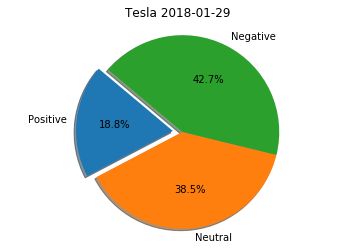

In [3]:
pie_chart('sentiment_data/TESLA_Sentiment/TESLA_Sentiment_2018-01-29.csv', 'Tesla 2018-01-29')

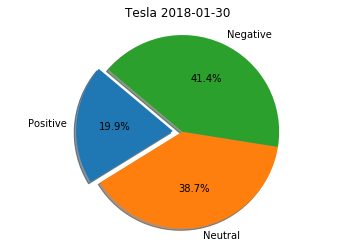

In [5]:
pie_chart('sentiment_data/TESLA_Sentiment/TESLA_Sentiment_2018-01-30.csv', 'Tesla 2018-01-30')

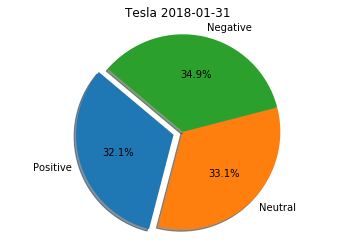

In [6]:
pie_chart('sentiment_data/TESLA_Sentiment/TESLA_Sentiment_2018-01-31.csv', 'Tesla 2018-01-31')

In [8]:
from datetime import datetime

In [34]:
def compile_sentiments_df(file_path,number_csv_files):
    '''
    This script will automatically compile data from subsequently dated .csv files.

    file_path: Type str. Path to the first sentiment file.
    - Expected input format: "/pathto/CompanyName_Sentiment_year-month-day.csv'
    - Example input format: "/pathto/TESLA_Sentiment_1996-01-01.csv'
    number_csv_files: Type int. Specify total number of csv sentiment files
    - Note file names must be consistent, with only the date changing from file to file.

    Returns: DataFrame of daily averaged sentiments with dates as index.

    Rules for sentiment data files:
    1. Maintain file name in accordance to file_path described above. 
       Only file name's date is allowed to change from .csv to next.
    2. Ensure file name date corresponds with data (it will be used to generate date_range)
    3. CSV file columns must follow: text,dates,retweets,favorites,negative,neutral,positive,compound

    '''
    assert isinstance(file_path,str)
    assert isinstance(number_csv_files,int)
    assert number_csv_files > 0

    import re # Regular expressions


    # Parse string only.
    parsed_file_name = file_path.split('/')[-1].split('_') # Get data contained in the file name
    parsed_file_name = {"Company Name":parsed_file_name[0], "Type of Data":parsed_file_name[1], 
                        "Date":parsed_file_name[-1].split('.')[0]}
    print parsed_file_name

    date_start = parsed_file_name["Date"] # Gets date from file name for auto file parsing
    build_compounds = []

    for items in pd.date_range(date_start, periods=number_csv_files+1, freq='24H'):
        file_path = re.sub(r'\d\d\d\d-\d\d-\d\d', items.strftime('%Y-%m-%d'), file_path)
        try:
            temp_df = pd.read_csv(file_path,sep=',')
            build_compounds.append(temp_df['compound'].mean())
        except IOError:
            if len(build_compounds) == 0:
                raise IOError("File not found. Please check your file path input.")
            else:
                print "Reached end of files. Success!"
            date_end = file_path.split('/')[-1].split('_')[2].split('.')[0]

    build_dates = pd.date_range(date_start, periods=number_csv_files, freq='24H')
    return pd.DataFrame(index = build_dates, data = build_compounds, columns = ["Sentiments"])

In [18]:
sentiments_df = compile_sentiments_df('./sentiment_data/TESLA_Sentiment/TESLA_Sentiment_2018-01-29.csv',10)

Reached end of files. Success!


In [20]:
def compile_stock_df(file_path,df_to_concat):
    '''
    file_path: Type str.
    df_to_concat: Type DataFrame. Data to concat stocks with.

    Rules for stock data files:
    1. First column should be "Unnamed: 0"

    Returns a DataFrame object with stock data merged with df_to_concat.
    '''
    assert isinstance(file_path,str)
    assert isinstance(df_to_concat,pd.DataFrame), "Is your input a DataFrame instance?"

    #Concatenate with stock prices
    temp_df = pd.read_csv(file_path,sep=',')
    temp_df.rename(columns = {'Unnamed: 0':'Date'},inplace=True) # Reassign 1st column to index
    temp_df.set_index('Date', inplace = True)
    temp_df.index = pd.to_datetime(temp_df.index).date
    return pd.concat([df_to_concat,temp_df], axis=1)

In [21]:
entire_df = compile_stock_df('./stock_data/TESLA_stock_data/TSLA_86400_NASDAQ_5Y.csv', sentiments_df)

In [23]:
def extract_subset(start_date, num_days, data):
    '''
    data: type DataFrame. Index should be DateTime.
    start_date: type str. Format: "year-month-day"
    num_days: type int. Number of days from start_date

    Returns a DataFrame subset (all columns) from start_date to start_date + num_days
    '''
    assert isinstance(start_date,str)
    assert isinstance(num_days,int)
    assert isinstance(data,pd.DataFrame)
    desired_start_date = pd.to_datetime(start_date).date()
    desired_end_date = (desired_start_date+pd.DateOffset(days=num_days)).date()
    data_subset = data.loc[desired_start_date:desired_end_date]
    print "data subset\n", data_subset
    return data_subset

In [25]:
def plot_df(df_data, company_name):
    '''
    This function plots a single company's stocks and respective sentiment rating of tweets for given dates.

    df_data: type DataFrame. Columns: Index(DateTime),Sentiments,Open,High,Low,Close,Volume
    company_name: type str
    high_lows: type boolean. Enable for additional text.
    '''
    assert isinstance(df_data,pd.DataFrame)
    assert isinstance(company_name,str)
    dates = df_data.index.values
    company_stocks = df_data.iloc[:,4] # At close
    sentiments = df_data.iloc[:,0]
    assert bool(len(dates)), "Does your df_data contain valid data?"
    assert bool(len(company_stocks))
    assert bool(len(sentiments))
    assert (company_stocks.all() > 0)

    #debug use
    debug_data = df_data.iloc[:,2]

    fig,ax = subplots(nrows=2, sharex = True)
    fig.set_figheight(10)
    fig.set_figwidth(30)
    ax[0].plot(dates,company_stocks)
    ax[1].plot(dates,sentiments)
    ax[0].plot(dates,debug_data)
    ax[1].set_xlabel('Date')
    ax[0].set_ylabel('Stock Prices ($)')
    ax[1].set_ylabel('Sentiment Rating')
    title_text = company_name + ': Social Effects on Stock'
    ax[0].set_title(title_text)
#     ax[0].legend()
#     ax.set_xticks(np.arange(0, 10, 1))
#     ax.set_yticks(numpy.arange(0, 1., 0.1))
    ax[0].grid(b=True, which='both')
    ax[1].grid(b=True, which='both')
    ax[0].set_xticks(dates[1:-1:1],minor=True)
#     ax[0].tick_params('both', length=10, width=1, which='minor')
    plt.show()

data subset
            Sentiments    Open    High     Low   Close     Volume
2018-01-29    0.287659  339.85  350.85  338.28  349.53  4747149.0
2018-01-30    0.347516  345.14  348.27  342.17  345.82  4717700.0
2018-01-31    0.438198  347.51  356.19  345.19  354.31  6214069.0
2018-02-01    0.390623  351.00  359.66  348.63  349.25  4197687.0
2018-02-02    0.382135  348.44  351.95  340.51  343.75  3704836.0
2018-02-03    0.340697     NaN     NaN     NaN     NaN        NaN
2018-02-04    0.298167     NaN     NaN     NaN     NaN        NaN
2018-02-05    0.286705  337.97  344.47  333.00  333.13  4464147.0
2018-02-06    0.311353  325.21  336.22  323.50  333.97  5088438.0
2018-02-07    0.316180  338.99  346.00  335.66  345.00  6969239.0


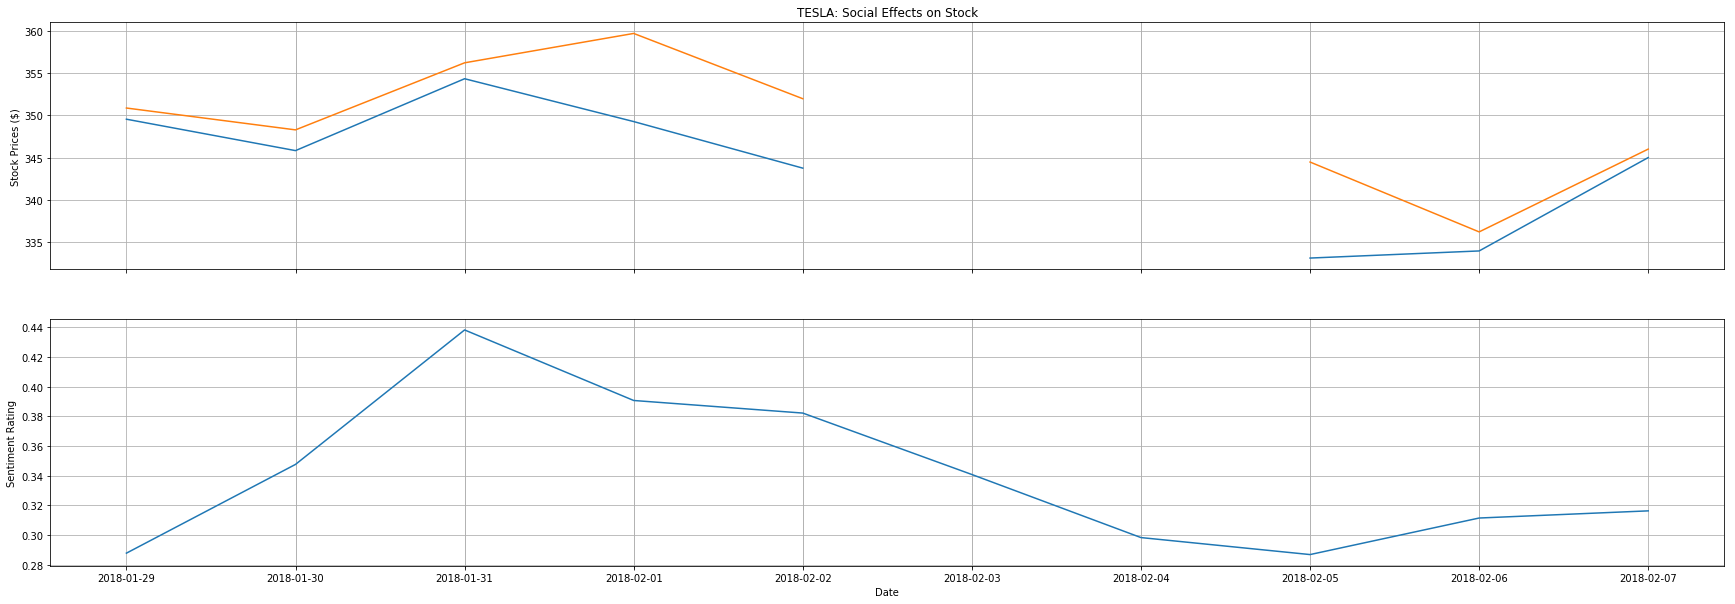

In [30]:
plot_df(extract_subset('2018-01-29',9,entire_df),"TESLA")

{'Date': '2017-04-04', 'Type of Data': 'Airlines', 'Company Name': 'United'}
Reached end of files. Success!
data subset
            Sentiments   Open   High    Low  Close      Volume
2017-04-04    0.236358  70.76  71.08  69.58  69.76   2658310.0
2017-04-05    0.294879  70.23  71.35  69.81  70.06   2640252.0
2017-04-06    0.264050  70.16  70.93  69.56  70.22   1874235.0
2017-04-07    0.228527  69.97  71.02  69.72  70.88   2471072.0
2017-04-08    0.245845    NaN    NaN    NaN    NaN         NaN
2017-04-09    0.262748    NaN    NaN    NaN    NaN         NaN
2017-04-10    0.091012  70.55  72.10  70.25  71.52   3460363.0
2017-04-11    0.170920  70.15  70.72  68.36  70.71  17696474.0
2017-04-12    0.235945  71.65  71.73  69.69  69.93   7622861.0
2017-04-13    0.257406  69.90  70.14  69.07  69.07   5185216.0


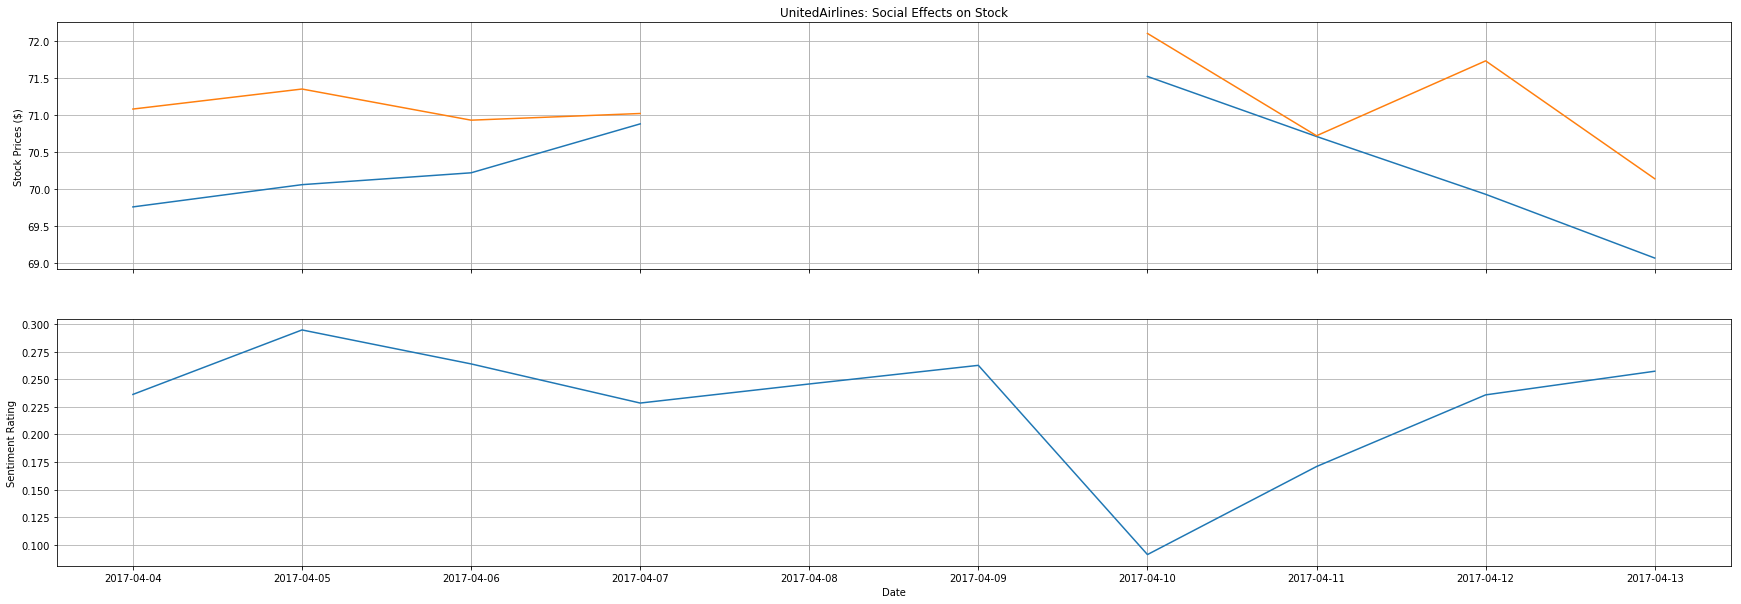

In [35]:
sentiments_df = compile_sentiments_df('./sentiment_data/UnitedAirlines_Sentiment/United_Airlines_Sentiment_2017-04-04.csv',10)
entire_df = compile_stock_df('./stock_data/UnitedAirlines_stock_data/UAL_86400_NYSE_5Y.csv', sentiments_df)
plot_df(extract_subset('2017-04-04',10,entire_df),"UnitedAirlines")

In [48]:
stock_data = pd.read_csv('stock_data/TESLA_stock_data/TSLA_86400_NASDAQ_5Y.csv')
stock_data

,Unnamed: 0,Open,High,Low,Close,Volume
0,2013-03-04 13:00:00,34.77,35.8300,34.7000,35.580,1757660
1,2013-03-05 13:00:00,36.00,36.9200,35.7900,36.650,2086969
2,2013-03-06 13:00:00,37.01,37.8800,36.9700,37.690,1149925
3,2013-03-07 13:00:00,37.73,38.6500,36.8800,38.230,1158354
4,2013-03-08 13:00:00,38.06,39.4400,37.3600,38.470,912052
5,2013-03-11 13:00:00,38.87,39.4400,38.6500,39.100,1579440
6,2013-03-12 13:00:00,38.90,39.3800,38.8500,39.120,1275062
7,2013-03-13 13:00:00,39.00,39.4900,38.8100,38.980,821986
8,2013-03-14 13:00:00,38.90,38.9100,36.7700,36.850,2024459
9,2013-03-15 13:00:00,36.64,36.6500,35.2100,35.290,3279777


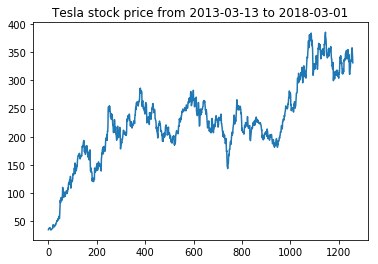

In [52]:
plt.figure
plt.title('Tesla stock price from 2013-03-13 to 2018-03-01')
plt.plot(stock_data.iloc[:, 4])
plt.show()

In [53]:
stock_data = pd.read_csv('stock_data/UnitedAirlines_stock_data/UAL_86400_NYSE_5Y.csv')
stock_data

,Unnamed: 0,Open,High,Low,Close,Volume
0,2013-03-04 13:00:00,27.220,28.9800,27.2200,28.82,6305746
1,2013-03-05 13:00:00,28.890,29.8700,28.8400,29.55,7647808
2,2013-03-06 13:00:00,29.670,29.8800,29.1700,29.30,4239308
3,2013-03-07 13:00:00,29.300,29.9700,29.1100,29.61,5676789
4,2013-03-08 13:00:00,29.990,31.6400,29.9550,31.35,9981728
5,2013-03-11 13:00:00,30.930,31.0800,30.3500,30.61,5509447
6,2013-03-12 13:00:00,30.590,30.8100,29.9200,29.95,5704167
7,2013-03-13 13:00:00,30.050,30.9100,29.7500,30.84,4759998
8,2013-03-14 13:00:00,30.780,31.2500,30.5600,31.17,3709690
9,2013-03-15 13:00:00,31.120,31.3500,30.7800,30.94,5810108


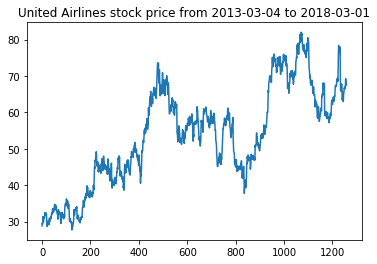

In [55]:
plt.figure
plt.title('United Airlines stock price from 2013-03-04 to 2018-03-01')
plt.plot(stock_data.iloc[:, 4])
plt.show()